# Cross validation in Machine Learning

Filippo Maria Bianchi

## Introduction

### What is cross-validation (CV)?

> Any **model validation** techniques used for assessing how the results of a statistical analysis will generalize to an **independent** data set.
- In Machine Learning (ML) it is used for:
    - Estimate the performance of a model on **out-of-sample data**.
    - Perform **model selection** (**compare** different models and perform hyperparameters **tuning**).
    - Assess the **quality** of a fitted model and the **stability** of its parameters.


### 🤔 Why do we care?

- CV helps to detect issues such as **overfitting** and **selection bias**.
- These can produce bad results that lead to **wrong conclusions**.
- Applying CV properly might be more important than learning how to use sophisticated ML models!

---


## Downstream task, data, and models

- Let's consider a **supervised setting** such as *classification* or *regression*.
- Our data consists of inputs $\mathbf{X}$ and outputs $\mathbf{y}$.
- In an image classification task, $\mathbf{X} \in \mathbb{R}^{N \times F}$ represents a collection of $N$ (vectorized) images of size $F$.
- Each image $\mathbf{x}_i \in \mathbb{R}^F$ is associated with a label $y_i$.

- Assume the data are split in a training and test set.
- The **training** set is used to fit the parameters of the model.
- The **test** set represent data that are not accessible during training.

<img src="figs/tr-test.png" style="width: 60%; display: block; margin: auto;">

- Assume we have a collection of models $\{M_1, M_2, \dots, M_K\}$. 
- Each model is parametrized by tunable parameters $\{\Theta_1, \Theta_2, \dots, \Theta_K\}$.
- Our goal is to find the **best** model and configuration of parameters that better classify new images (test set).

In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn import datasets
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    LeaveOneOut
)
np.set_printoptions(threshold=3, edgeitems=3)

- Let's consider a classic ML dataset: $\texttt{Olivetti Faces}$.
- Each samples is a $64 \times 64$ image (vectorized in $F=4096$ dimensions).
- There are $N=400$ pictures of faces taken from $40$ employees at $10$ different angles.
- The class is the ID of the employee in the picture.

In [2]:
# Load the data
X, y = datasets.fetch_olivetti_faces(return_X_y=True)
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


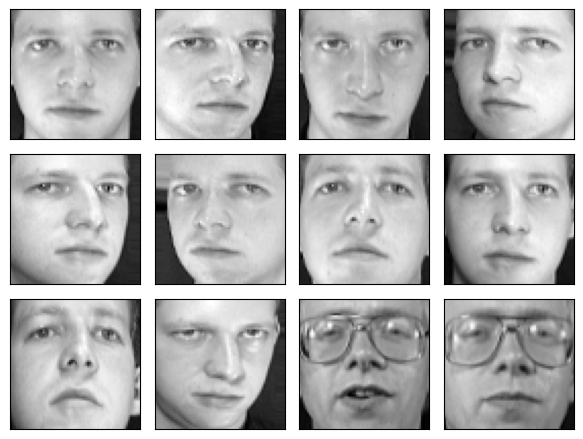

In [3]:
def plot_grid(images, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.5 * n_col, 1.5 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.0, wspace=.05)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape(h, w), cmap=plt.cm.gray)
        plt.xticks(()), plt.yticks(())
        
plot_grid(X, 64, 64)
plt.tight_layout();

- In this case, the data are **not** split into train and test set.
- We have to do the split ourselves: we reserve 80% of the data for training and 20% for testing.
- We also make sure to **shuffle** the data and **stratify** the split by class.

> ⚠️ Note that this split is **arbitrary** and might not be ideal.

In [4]:
# Split the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y # ensure having same class proportions in both sides of the split
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (320, 4096), X_test: (80, 4096)
y_train: (320,), y_test: (80,)


We can see that:

1. The data are now shuffled:

In [5]:
print(y) # original data

[ 0  0  0 ... 39 39 39]


In [6]:
print(y_train) # train set 

[13  5  3 ... 21  2  6]


2. We stratified the split by class

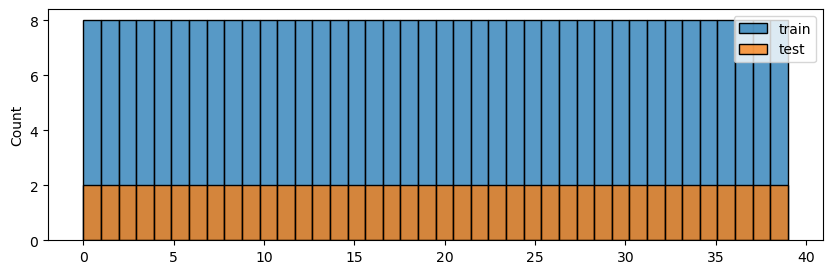

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
sns.histplot(y_train, bins=40, ax=ax, label='train')
sns.histplot(y_test, bins=40, ax=ax, label='test')
plt.legend();

- Next, we must **choose** a classifier.
- Which one to choose?
- We have many options.

<img src="figs/classifiers-h.png" style="width: 100%; display: block; margin: auto;">

- Here, we consider a `RandomForestClassifier` and a `SVC` classifier.
- For `SVC`, we specify $C$ (regularization) and $\gamma$ (kernel width).
- For `RandomForestClassifier`, we specify the hypeparameters `n_estimators` and `max_depth`.
- For now, we set these values arbitrarily.

In [8]:
clf_svc = SVC(kernel='rbf', gamma=0.1, C=10.0,
          random_state=42)
print(clf_svc)

SVC(C=10.0, gamma=0.1, random_state=42)


In [9]:
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42)
print(clf_rf)

RandomForestClassifier(max_depth=10, random_state=42)


- Next, we **train** the classifiers.
- Training = adapting the models' parameters to the training data.

<img src="figs/training.png" style="width: 55%; display: block; margin: auto;">

In [10]:
clf_svc.fit(X_train, y_train)

SVC(C=10.0, gamma=0.1, random_state=42)

In [11]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

---

## Model selection with cross-validation

- After the models are trained, we want to **compare** them.
- We want to select the one that achieves the **best performance**.
- Here, we consider classification *accuracy* and *F1 score*.

- A common **mistake** is to compute the performance on the training set.

In [12]:
y_pred = clf_svc.predict(X_train)
print(f"SVC Accuracy: {accuracy_score(y_train, y_pred):.2f}")
print(f"SVC F1 score: {f1_score(y_train, y_pred, average='weighted'):.2f}\n")

y_pred = clf_rf.predict(X_train)
print(f"RF Accuracy: {accuracy_score(y_train, y_pred):.2f}")
print(f"RF F1 score: {f1_score(y_train, y_pred, average='weighted'):.2f}")

SVC Accuracy: 1.00
SVC F1 score: 1.00

RF Accuracy: 1.00
RF F1 score: 1.00


- In this case both classifiers achieve perfect scores.
- Why is this evaluation is wrong?

- This does not represents the **generalization capability** of the model (e.g., performance on unseen data).
- A model with enough capacity can just **"memorize"** all training data and perform poorly on new samples.
- This is called **overfitting**.

### Validation set

- We need to create a **validation set**.
- The validation set is *not* used to fit the model parameters.
- It is only used to evaluate the **predictive performance** of the model.

- To create a validation set we could set aside a chunk of the training data.

<img src="figs/val-split1.png" style="width: 55%; display: block; margin: auto;">

In [13]:
# Split 80% train - 20% validation
X_train_split, X_val = (
    X_train[: int(0.8 * len(X_train))],
    X_train[int(0.8 * len(X_train)) :])

y_train_split, y_val = (
    y_train[: int(0.8 * len(y_train))],
    y_train[int(0.8 * len(y_train)) :])

print(f"X_train_split: {X_train_split.shape}, X_val: {X_val.shape}")
print(f"y_train_split: {y_train_split.shape}, y_val: {y_val.shape}")

X_train_split: (256, 4096), X_val: (64, 4096)
y_train_split: (256,), y_val: (64,)


- Now we can retrain the models and test their performance, this time on the validation set.

In [14]:
# Fit the models
clf_svc.fit(X_train_split, y_train_split)
clf_rf.fit(X_train_split, y_train_split)

y_pred = clf_svc.predict(X_val)
print(f"SVC Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(f"SVC F1 score: {f1_score(y_val, y_pred, average='weighted'):.2f}\n")

y_pred = clf_rf.predict(X_val)
print(f"RF Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(f"RF F1 score: {f1_score(y_val, y_pred, average='weighted'):.2f}")

SVC Accuracy: 0.25
SVC F1 score: 0.30

RF Accuracy: 0.75
RF F1 score: 0.76


- The situation is very different now...

- Are these new performance a good proxy for estimating the generalization capability of the models?
- What if we used a **different split** for train and validation?


<img src="figs/val-split2.png" style="width: 55%; display: block; margin: auto;">

### $K$-fold cross-validation

- In general, we want to use **all** the chunks either for training or for validation, at least once.
- We create $K$ splits: in turn, use one for validation and the rest for train.
- The final performance is given by the metrics **aggregated** from each split.

<img src="figs/kfold.png" style="width: 100%; display: block; margin: auto;">

In [15]:
n_splits = 8
cv = KFold(n_splits=n_splits)

In [16]:
def compute_cv_results(X, y, cv, clf, quiet=False):
    accuracies = []
    f1_scores = []
    for i, (train_index, test_index) in enumerate(cv.split(X, y=y)):
        
        # Get the next split
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        # Fit the model
        clf.fit(X_train, y_train)
        
        # Compute predictions on fold i
        y_pred = clf.predict(X_val)
        accuracies.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        if not quiet:
            print(f"Fold {i} > accuracy: {accuracies[-1]:.2f}, F1 Score: {f1_scores[-1]:.2f}")

    # Aggregate results
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    print(f"Mean accuracy: {mean_accuracy:.2f} +/- {std_accuracy:.2f}")
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print(f"Mean F1 score: {mean_f1:.2f} +/- {std_f1:.2f}")

In [17]:
# Perform cv with SVC
compute_cv_results(X_train, y_train, cv, clf_svc)

Fold 0 > accuracy: 0.28, F1 Score: 0.32
Fold 1 > accuracy: 0.30, F1 Score: 0.33
Fold 2 > accuracy: 0.30, F1 Score: 0.32
Fold 3 > accuracy: 0.38, F1 Score: 0.42
Fold 4 > accuracy: 0.28, F1 Score: 0.30
Fold 5 > accuracy: 0.38, F1 Score: 0.42
Fold 6 > accuracy: 0.20, F1 Score: 0.23
Fold 7 > accuracy: 0.35, F1 Score: 0.39
Mean accuracy: 0.31 +/- 0.06
Mean F1 score: 0.34 +/- 0.06


In [18]:
# Perform cv with RF
compute_cv_results(X_train, y_train, cv, clf_rf)

Fold 0 > accuracy: 0.88, F1 Score: 0.88
Fold 1 > accuracy: 0.80, F1 Score: 0.80
Fold 2 > accuracy: 0.70, F1 Score: 0.70
Fold 3 > accuracy: 0.78, F1 Score: 0.78
Fold 4 > accuracy: 0.68, F1 Score: 0.68
Fold 5 > accuracy: 0.78, F1 Score: 0.78
Fold 6 > accuracy: 0.78, F1 Score: 0.77
Fold 7 > accuracy: 0.70, F1 Score: 0.74
Mean accuracy: 0.76 +/- 0.06
Mean F1 score: 0.77 +/- 0.06


- Based on the results, it seems that the RF classifier is doing a better job.
- However, we are not done yet: model selection also involves searching for the **optimal hyperparameters**!
- Hyperparameters search can be done with a simple **grid search** or with more sophisticated techniques.

<img src="figs/grid-search.png" style="width: 30%; display: block; margin: auto;">

- In the following, we will search the values of $\gamma$ for the `SVC` classifier.
- So far, we used `0.1`.
- Now, we will try `0.5` and `0.01`.

In [19]:
gamma_values = [0.5, 0.01]
for g in gamma_values:
    clf_svc = SVC(kernel='rbf', gamma=g, C=10.0, random_state=42)
    print(f"gamma = {g}")
    compute_cv_results(X_train, y_train, cv, clf_svc, quiet=True)
    

gamma = 0.5
Mean accuracy: 0.00 +/- 0.01
Mean F1 score: 0.00 +/- 0.01
gamma = 0.01
Mean accuracy: 0.94 +/- 0.03
Mean F1 score: 0.94 +/- 0.03


- It turns out that by changing the hyperparameter $\gamma$, `SVC` performs much better.
- There are **other** hyperparmeters to be optimized and this should be done for **all** models.
- There are **more efficient** strategies that grid search for tuning the hyperparameters.
- In general, hyperparameters optimization is **time consuming**.

- Assuming the model selection is over, we are finally ready to process the test data.

In [20]:
# Restore the best model found
best_clf_svc = SVC(kernel='rbf', gamma=0.01, C=10.0, random_state=42)

# Train the model one last time (here we can use the whole training set)
best_clf_svc.fit(X_train, y_train)

# Make preds on test set and compute results
y_pred = best_clf_svc.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Test F1 score: {f1_score(y_test, y_pred, average='weighted'):.2f}\n")

Test Accuracy: 0.97
Test F1 score: 0.97



- The whole procedure is summarized below.
- Note that we can think of the **choice of the model** itself as an hyperparameter.

<img src="figs/hp-scheme.png" style="width: 50%; display: block; margin: auto;">

---

## Other CV techniques

Let's look in more details at the performance achieved by `RandomForestClassifier` on each fold.

In [21]:
cv = KFold(n_splits=n_splits)
compute_cv_results(X_train, y_train, cv, clf_rf)

Fold 0 > accuracy: 0.88, F1 Score: 0.88
Fold 1 > accuracy: 0.80, F1 Score: 0.80
Fold 2 > accuracy: 0.70, F1 Score: 0.70
Fold 3 > accuracy: 0.78, F1 Score: 0.78
Fold 4 > accuracy: 0.68, F1 Score: 0.68
Fold 5 > accuracy: 0.78, F1 Score: 0.78
Fold 6 > accuracy: 0.78, F1 Score: 0.77
Fold 7 > accuracy: 0.70, F1 Score: 0.74
Mean accuracy: 0.76 +/- 0.06
Mean F1 score: 0.77 +/- 0.06


- There is a very **high variance** between the folds.
- Why is this happening?

- Class distribution can change a lot between train and validation splits.

Let's visualize the class distributions in each split. The code adapted from [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#define-a-function-to-visualize-cross-validation-behavior).

In [22]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=20, cmap_cv=plt.cm.coolwarm, cmap_data=plt.cm.Paired):    
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        # xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

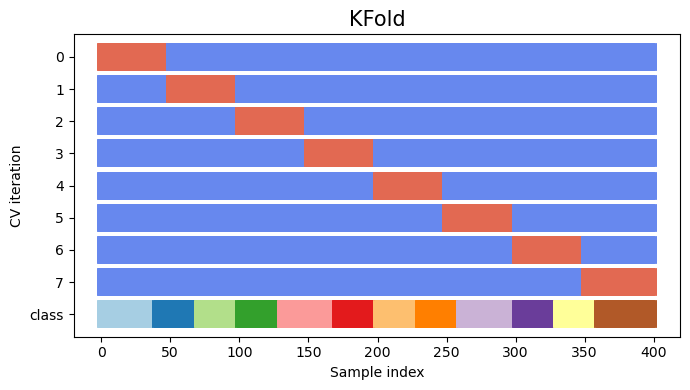

In [23]:
# We consider the original dataset here (before train/test split)
cv = KFold(n_splits=n_splits)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
plot_cv_indices(cv, X, y, ax, n_splits=n_splits)
plt.tight_layout();

- The problem is mitigated if we **shuffle** the data.
- Remember, that's what we did at the beginning (train/test split).

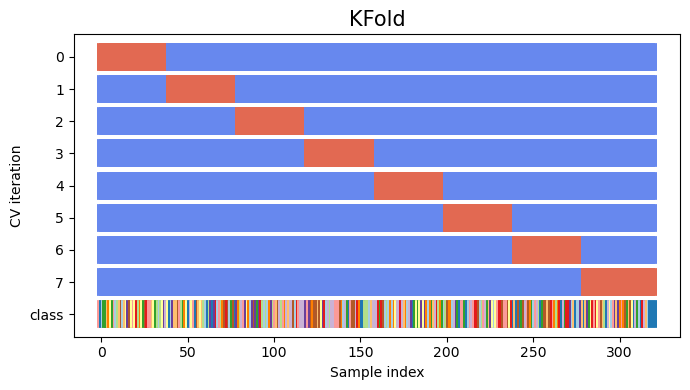

In [24]:
cv = KFold(n_splits=n_splits)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
plot_cv_indices(cv, X_train, y_train, ax, n_splits=n_splits)
plt.tight_layout()
plt.show()

However:
- Shuffling does not ensure that class distributions are well **preserved** in each CV split.
- If samples are not i.i.d. (e.g., in a time series) shuffling can lead to **overfit** and **inflated** validation score.
- In the latter case, the model will be tested on samples that are artificially similar (close in time) to training samples.

### Stratified $K$-fold CV

- Ensures that the class distribution is the same in each split of the $K$ folds.

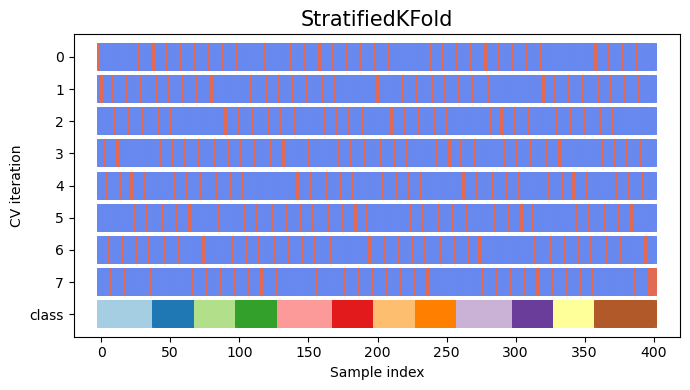

In [25]:
cv = StratifiedKFold(n_splits=n_splits)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
plot_cv_indices(cv, X, y, ax, n_splits=n_splits)
plt.tight_layout();

We repeat the same experiment as before.

In [26]:
cv = StratifiedKFold(n_splits=n_splits)
compute_cv_results(X_train, y_train, cv, clf_rf)

Fold 0 > accuracy: 0.82, F1 Score: 0.77
Fold 1 > accuracy: 0.85, F1 Score: 0.81
Fold 2 > accuracy: 0.88, F1 Score: 0.83
Fold 3 > accuracy: 0.82, F1 Score: 0.77
Fold 4 > accuracy: 0.93, F1 Score: 0.90
Fold 5 > accuracy: 0.88, F1 Score: 0.83
Fold 6 > accuracy: 0.82, F1 Score: 0.77
Fold 7 > accuracy: 0.80, F1 Score: 0.75
Mean accuracy: 0.85 +/- 0.04
Mean F1 score: 0.81 +/- 0.05


- Now the variance is **much lower**.
- Also, the overall performance is higher since the model is trained and tested on **evenly distributed** classes.

### Leave-one-out CV

- CV is **computationally expensive**, but does not **waste data**.
- However, partitioning the data into training and validation **reduces the amount of samples** that can be used for learning the model.
- If we have **very small** datasets, we can consider **one sample at the time** as the validation set.


In [27]:
X, y = datasets.load_wine(return_X_y=True)
print(X.shape)
print(y.shape)

(178, 13)
(178,)


In [28]:
clf = SVC(kernel="linear", C=1.0, random_state=42)
cv = LeaveOneOut()

# Perform cross-validation
accuracies = []
f1_scores = []
for train_index, test_index in tqdm(
    cv.split(X, y=y), total=len(X), desc="Cross-validation"
):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average="weighted"))

print(f"Mean accuracy: {np.mean(accuracies):.2f} +/- {np.std(accuracies):.2f}")
print(f"Mean F1 score: {np.mean(f1_scores):.2f} +/- {np.std(f1_scores):.2f}")

Cross-validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:05<00:00, 31.61it/s]

Mean accuracy: 0.96 +/- 0.21
Mean F1 score: 0.96 +/- 0.21


## Further topics

### Nested CV
- We **arbitrarily** split train and test at the beginning.
- The same principle applies here: each chunk of the data should be in turn the test set (**outer split**)
- The training data are split one more time to get the validation set for model selection (**inner split**)

### Cross validation of time series data
- $k$-fold CV and shuffling assumes data are i.i.d.
- That is not the case for time series data.
- Split should be done to **preserve the temporal ordering** in the data.

### CV for grouped data
- The i.i.d. assumption is broken if the dataset contains **groups of dependent samples**.
- Does a model trained on a particular set of groups generalizes well to the **unseen groups**?
- We need to ensure that all the samples in the validation fold come from groups that are **not represented** in the training fold.

